# Results, section 2:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ptitprince as pt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, update_progress, get_null_p, get_cmap, get_fdr_p_df, get_sys_summary, prop_bar_plot

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer'
parc_scale = 400 # 200 400 | 60 125
primary_covariate = 'ageAtScan1_Years'
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

In [4]:
sns.set(style='white', context = 'paper', font_scale = 1)

In [6]:
run_correlations = True
compute_perm_stats = False
num_perms = 1000

In [7]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400_streamlineCount/ageAtScan1_Years+sex_adj'

In [8]:
metrics = ('ct', 'str', 'ac', 'mc')
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')

## Load data pre-nispat data

In [9]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid'], inplace = True); print(df.shape)
df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

(317, 21)
(783, 21)


## Age effects

In [10]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [11]:
age_filter.sum()

1012

## Load nispat outputs

In [12]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

In [13]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns)

In [16]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [17]:
smse_filter.sum()

1023

### The interpretation of the z-deviations varies as a function of the age-effect from which the normative model is primarily derived.
### For instance, if the normative model predicts a _decrease_ in y with age, then _positive deviations_ may be interpreted as a **_delay_** in this maturational reduction, wheras _negative deviations_ may be interpreted as an _advancement_ in this maturational reduction.
### However, if the normative model predicts an _increase_ in y with age, then the interpretation of the deviations is reversed. That is:
#### IF predicted change = negative: _positive deviations_ = **_delay_** || _negative deviations_ = **_advance_**
#### IF predicted change = positive: _positive deviations_ = **_advance_** || _negative deviations_ = **_delay_**

In [18]:
# at each roi, the differences between first and last age point in the synthetic data
# for each node/metric, a negative value means that the nm predicted an overall decrease in y with age (i.e, a negative function),
# while a positive values means that the nm predicted an overall increase in y with age (i.e., a positive function)
df_yhat_tmp1 = df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 0].iloc[0,:]
df_yhat_tmp2 = df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[-1,:] - df_yhat_forward[synth_cov_test['sex_adj'] == 1].iloc[0,:]
df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)

# boolean that designates which regions carry with positive predicted change.
nm_is_pos = df_yhat_diff[0] > 0

# flipping the z-stats in these regions has the effect of standardising their interpration across the brain to be inline
# with the negative predicted change statement above
df_z.loc[:,nm_is_pos] = df_z.loc[:,nm_is_pos] * -1

## Get pheno-metric relationshisps

In [19]:
if run_correlations:
    df_pheno = pd.DataFrame(columns = ['pheno','node','coef', 'p'])
    df_corr_input = pd.concat((df.loc[:,phenos], df_node), axis = 1)

    # regress out age
    df_nuis = df[primary_covariate]
    df_nuis = sm.add_constant(df_nuis)
    cols = df_corr_input.columns
    mdl = sm.OLS(df_corr_input.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = cols
    df_corr_input.loc[:,cols] = df_corr_input.loc[:,cols] - y_pred

    for pheno in phenos:
        print(pheno)
        df_tmp = pd.DataFrame(index = df_node.columns, columns = ['coef', 'p'])
        for col in df_node.columns:
            df_tmp.loc[col,'coef'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
            df_tmp.loc[col,'p'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[1]
        df_tmp.reset_index(inplace = True); df_tmp.rename(index=str, columns={'index': 'node'}, inplace = True); df_tmp['pheno'] = pheno
        df_pheno = df_pheno.append(df_tmp, sort = False)

    df_pheno.set_index(['pheno','node'], inplace = True)

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Overall_Psychopathology
Psychosis_Positive
Psychosis_NegativeDisorg
AnxiousMisery
Externalizing
Fear


### Get null for pheno-metric

In [20]:
if compute_perm_stats:
    for pheno in phenos:
        # Set seed for reproducibility
        np.random.seed(0)
        null = np.zeros((df_node.shape[1],num_perms))

        df_tmp = pd.concat((df.loc[:,phenos], df_node), axis = 1)

        # regress out age
        df_nuis = df[primary_covariate]
        df_nuis = sm.add_constant(df_nuis)
        cols = df_tmp.columns
        mdl = sm.OLS(df_tmp.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
        y_pred = mdl.predict(df_nuis)
        y_pred.columns = cols
        df_tmp.loc[:,cols] = df_tmp.loc[:,cols] - y_pred
                                      
        for j in range(num_perms):
            update_progress(j / num_perms, pheno)
            df_corr_input = df_tmp.copy()
            df_corr_input.loc[:,df_node.columns] = df_corr_input.loc[:,df_node.columns].sample(frac = 1).values
            for i, col in enumerate(df_node.columns):
                null[i,j] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]

        update_progress(1, pheno)
        np.save(os.path.join(os.environ['NORMATIVEDIR'], 'null_' + pheno + '_m_spear_ols_res'), null)

    nulls = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_m_spear_ols_res.npy')),
            'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_m_spear_ols_res.npy')),
            'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_m_spear_ols_res.npy')),
            'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_m_spear_ols_res.npy')),
            'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_m_spear_ols_res.npy')),
            'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_m_spear_ols_res.npy'))}
else:
    nulls = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_m_spear_ols_res.npy')),
            'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_m_spear_ols_res.npy')),
            'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_m_spear_ols_res.npy')),
            'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_m_spear_ols_res.npy')),
            'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_m_spear_ols_res.npy')),
            'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_m_spear_ols_res.npy'))}

## Get pheno-nispat relationships

In [21]:
if run_correlations:
    df_pheno_z = pd.DataFrame(columns = ['pheno','node','coef', 'p'])
    df_corr_input = pd.concat((df.loc[:,phenos], df_z), axis = 1)

    # regress out age
    df_nuis = df[primary_covariate]
    df_nuis = sm.add_constant(df_nuis)
    cols = df_corr_input.columns
    mdl = sm.OLS(df_corr_input.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = cols
    df_corr_input.loc[:,cols] = df_corr_input.loc[:,cols] - y_pred

    for pheno in phenos:
        print(pheno)
        df_tmp = pd.DataFrame(index = df_z.columns, columns = ['coef', 'p'])
        for col in df_z.columns:
            df_tmp.loc[col,'coef'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
            df_tmp.loc[col,'p'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[1]
        df_tmp.reset_index(inplace = True); df_tmp.rename(index=str, columns={'index': 'node'}, inplace = True); df_tmp['pheno'] = pheno
        df_pheno_z = df_pheno_z.append(df_tmp, sort = False)

    df_pheno_z.set_index(['pheno','node'], inplace = True)
    df_pheno_z = df_pheno_z.astype(float)

Overall_Psychopathology
Psychosis_Positive
Psychosis_NegativeDisorg
AnxiousMisery
Externalizing
Fear


### Get null for pheno-nispat 

In [22]:
if compute_perm_stats:
    for pheno in phenos:
        null = np.zeros((df_z.shape[1],num_perms))

        for j in range(num_perms):
            update_progress(j / num_perms, pheno)
            # load permuted z-stats
            permdir = os.path.join(os.environ['NORMATIVEDIR'], 'perm_all/perm_' + str(j))
            z_file = os.path.join(permdir, 'Z.txt')
            z_p = np.loadtxt(z_file, delimiter = ' ').transpose()
            z_p[:,nm_is_pos.values] = z_p[:,nm_is_pos.values] * -1
            z_p = pd.DataFrame(data = z_p, index = df_z.index, columns = df_z.columns)
            df_corr_input = pd.concat((df.loc[:,phenos], z_p), axis = 1)

            # regress out age
            df_nuis = df[primary_covariate]
            df_nuis = sm.add_constant(df_nuis)
            cols = df_corr_input.columns
            mdl = sm.OLS(df_corr_input.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
            y_pred = mdl.predict(df_nuis)
            y_pred.columns = cols
            df_corr_input.loc[:,cols] = df_corr_input.loc[:,cols] - y_pred
            
            for i, col in enumerate(df_z.columns):
                null[i,j] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
        update_progress(1, pheno)

        np.save(os.path.join(os.environ['NORMATIVEDIR'], 'null_' + pheno + '_zp_all_spear_ols_res'), null)

    nulls_z = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_zp_all_spear_ols_res.npy')),
            'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_zp_all_spear_ols_res.npy')),
            'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_zp_all_spear_ols_res.npy')),
            'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_zp_all_spear_ols_res.npy')),
            'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_zp_all_spear_ols_res.npy')),
            'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_zp_all_spear_ols_res.npy'))}    
else:
    nulls_z = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_zp_all_spear_ols_res.npy')),
        'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_zp_all_spear_ols_res.npy')),
        'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_zp_all_spear_ols_res.npy')),
        'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_zp_all_spear_ols_res.npy')),
        'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_zp_all_spear_ols_res.npy')),
        'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_zp_all_spear_ols_res.npy'))}

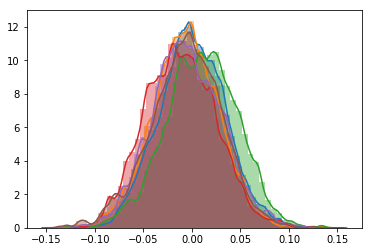

In [23]:
for pheno in phenos:
    nulls_z[pheno][np.isnan(nulls_z[pheno])] = 0
    sns.distplot(nulls_z[pheno].reshape(-1,1))

In [24]:
if run_correlations == False:
    df_pheno = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno.csv'))
    df_pheno.set_index(['pheno','node'], inplace = True)
    
    df_pheno_z = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))
    df_pheno_z.set_index(['pheno','node'], inplace = True)

In [25]:
for pheno in phenos:
    df_pheno.loc[pheno,'p_perm'] = get_null_p(df_pheno.loc[pheno,'coef'].values, nulls[pheno])    
    df_pheno.loc[pheno,'p_perm_fdr'] = get_fdr_p(df_pheno.loc[pheno,'p_perm'])
print(str(np.sum(df_pheno['p_perm_fdr'] < .05)) + ' significant effects (fdr)')

11 significant effects (fdr)


In [26]:
for pheno in phenos:
    df_pheno_z.loc[pheno,'p_perm'] = get_null_p(df_pheno_z.loc[pheno,'coef'].values, nulls_z[pheno])    
    df_pheno_z.loc[pheno,'p_perm_fdr'] = get_fdr_p(df_pheno_z.loc[pheno,'p_perm'])
print(str(np.sum(df_pheno_z['p_perm_fdr'] < .05)) + ' significant effects (fdr)')

1055 significant effects (fdr)


In [27]:
alpha = 0.05/len(phenos)
print(len(phenos))
print(alpha)

6
0.008333333333333333


In [28]:
x = df_pheno['p_perm_fdr'].values < alpha
df_pheno['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(age_filter, 1, len(phenos))
z = np.matlib.repmat(smse_filter, 1, len(phenos))

my_bool = np.concatenate((x, y)); region_filter = np.all(my_bool, axis = 0); df_pheno['sig_age'] = region_filter
my_bool = np.concatenate((x, y, z)); region_filter = np.all(my_bool, axis = 0); df_pheno['sig_age_smse'] = region_filter

print(str(np.sum(df_pheno['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno['sig_age'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno['sig_age_smse'] == True)) + ' significant effects (fdr)')

############
x = df_pheno_z['p_perm_fdr'].values < alpha
df_pheno_z['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(age_filter, 1, len(phenos))
z = np.matlib.repmat(smse_filter, 1, len(phenos))

my_bool = np.concatenate((x, y)); region_filter = np.all(my_bool, axis = 0); df_pheno_z['sig_age'] = region_filter
my_bool = np.concatenate((x, y, z)); region_filter = np.all(my_bool, axis = 0); df_pheno_z['sig_age_smse'] = region_filter

print(str(np.sum(df_pheno_z['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_age'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_age_smse'] == True)) + ' significant effects (fdr)')

11 significant effects (fdr)
8 significant effects (fdr)
7 significant effects (fdr)
485 significant effects (fdr)
317 significant effects (fdr)
244 significant effects (fdr)


In [29]:
for pheno in phenos:
    print(pheno + ': ' + str(np.sum(df_pheno.loc[pheno]['sig_age_smse'] == True)) + ' significant effects (fdr)')

Overall_Psychopathology: 0 significant effects (fdr)
Psychosis_Positive: 1 significant effects (fdr)
Psychosis_NegativeDisorg: 2 significant effects (fdr)
AnxiousMisery: 0 significant effects (fdr)
Externalizing: 1 significant effects (fdr)
Fear: 3 significant effects (fdr)


In [30]:
for pheno in phenos:
    print(pheno + ': ' + str(np.sum(df_pheno_z.loc[pheno]['sig_age_smse'] == True)) + ' significant effects (fdr)')

Overall_Psychopathology: 2 significant effects (fdr)
Psychosis_Positive: 17 significant effects (fdr)
Psychosis_NegativeDisorg: 22 significant effects (fdr)
AnxiousMisery: 24 significant effects (fdr)
Externalizing: 73 significant effects (fdr)
Fear: 106 significant effects (fdr)


In [31]:
df_pheno.to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno.csv'))
df_pheno_z.to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))

# Plots

In [32]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')
metrics = ('ct', 'str', 'ac', 'mc')
metrics_label_short = ('Thickness', 'Strength', 'Ave. ctrb.', 'Mod. ctrb.')
metrics_label = ('Thickness', 'Strength', 'Average controllability', 'Modal controllability')

# For sensitivity analyses
# metrics = ('str', 'ac', 'mc')
# metrics_label_short = ('Strength', 'Ave. ctrb.', 'Mod. ctrb.')
# metrics_label = ('Strength', 'Average controllability', 'Modal controllability')

# metrics = ('ac', 'mc')
# metrics_label_short = ('Ave. ctrb.', 'Mod. ctrb.')
# metrics_label = ('Average controllability', 'Modal controllability')

print(phenos)
print(metrics)

metrics_labels = list()
for metric in metrics:
    tmp_labels = [metric + '_' + str(i) for i in range(num_parcels)]
    metrics_labels = metrics_labels + tmp_labels

('Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear')
('ct', 'str', 'ac', 'mc')


## Number of sig effects

In [33]:
arrays = [tuple(['pre-nm'] * len(metrics) + ['nm'] * len(metrics)), metrics + metrics]
my_index = pd.MultiIndex.from_arrays(arrays, names=('analysis', 'metric'))
pos_counts = pd.DataFrame(index = my_index, columns = phenos)
neg_counts = pd.DataFrame(index = my_index, columns = phenos)

In [34]:
for pheno in phenos:
    for metric in metrics:
        age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
        smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
        smse_filt = smse_filt.reshape(-1)
        region_filt = np.logical_and(age_filt,smse_filt)
        
        df_tmp = df_pheno.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        pos_counts.loc[('pre-nm',metric),pheno] = df_tmp.loc[df_tmp['coef']>0,'sig_age_smse'].sum() / region_filt.sum()*100
        neg_counts.loc[('pre-nm',metric),pheno] = df_tmp.loc[df_tmp['coef']<0,'sig_age_smse'].sum() / region_filt.sum()*100
        
        df_tmp = df_pheno_z.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        pos_counts.loc[('nm',metric),pheno] = df_tmp.loc[df_tmp['coef']>0,'sig_age_smse'].sum() / region_filt.sum()*100
        neg_counts.loc[('nm',metric),pheno] = df_tmp.loc[df_tmp['coef']<0,'sig_age_smse'].sum() / region_filt.sum()*100

In [35]:
pos_counts

Overall_Psychopathology Psychosis_Positive  \
analysis metric                                              
pre-nm   ct                           0                  0   
         str                          0                  0   
         ac                           0                  0   
         mc                           0                  0   
nm       ct                           0           0.571429   
         str                          0            2.32558   
         ac                    0.487805            2.43902   
         mc                           0           0.823045   

                Psychosis_NegativeDisorg AnxiousMisery Externalizing     Fear  
analysis metric                                                                
pre-nm   ct                     0.571429             0             0        0  
         str                           0             0             0        0  
         ac                            0             0             0        0  
         mc                            0             0      0.411523        0  
nm       ct                      3.14286             4       1.14286        6  
         str                     2.32558             0       2.32558  6.97674  
         ac                            0             0             0  8.29268  
         mc                            0       1.64609      0.411523  11.9342

In [36]:
if np.max(pos_counts.values) > np.max(neg_counts.values):
    plot_max = np.round(np.max(pos_counts.values),0)
elif np.max(pos_counts.values) < np.max(neg_counts.values):
    plot_max = np.round(np.max(neg_counts.values),0)
elif np.max(pos_counts.values) == np.max(neg_counts.values):
    plot_max = np.round(np.max(pos_counts.values),0)
print(plot_max)

12.0


Figure 3A

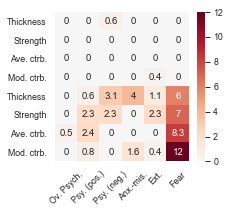

In [37]:
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(2.75)
ax = sns.heatmap(np.round(pos_counts.astype(float),1), center = 0, vmax = plot_max, annot = True, cmap = 'RdBu_r')
ax.set_xticklabels(phenos_label_short, rotation = 45)
ax.set_yticklabels(metrics_label_short + metrics_label_short)
ax.set_ylabel('')
f.savefig('pos_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

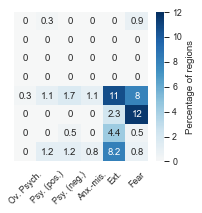

In [38]:
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(2.75)
ax = sns.heatmap(np.round(neg_counts.astype(float),1), center = 0, vmax = plot_max, annot = True, cmap = 'RdBu', cbar_kws={'label': 'Percentage of regions'})
ax.set_xticklabels(phenos_label_short, rotation = 45)
ax.set_yticklabels('')
ax.set_ylabel('')
f.savefig('neg_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## t-tests on distributions of coefficients

In [39]:
desc = pd.DataFrame(index = metrics, columns = phenos)
stats = pd.DataFrame(index = metrics, columns = phenos)
p = pd.DataFrame(index = metrics, columns = phenos)

for pheno in phenos:
    for metric in metrics:
        x = df_pheno_z.loc[pheno].loc[:,'coef'].filter(regex = metric, axis = 0)
        y = df_pheno.loc[pheno].loc[:,'coef'].filter(regex = metric, axis = 0)
        
        age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
        smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
        smse_filt = smse_filt.reshape(-1)
        region_filt = np.logical_and(age_filt,smse_filt)
        
        x = x[region_filt]; y = y[region_filt]
        desc.loc[metric,pheno] = np.median(x - y)
        
        stats.loc[metric,pheno] = sp.stats.wilcoxon(x, y)[0]
        p.loc[metric,pheno] = sp.stats.wilcoxon(x, y)[1] 
        
p = get_fdr_p_df(p)

In [40]:
desc[p < 0.05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,0.00072484,-0.00274599,-0.00420186,0.0039198,-0.00571578,0.00616398
str,NaN,NaN,NaN,-0.00845278,NaN,NaN
ac,0.00456197,-0.00740114,-0.00968121,0.0124325,-0.0147743,0.0162102
mc,NaN,-0.00828995,0.0329888,-0.0526866,-0.0146114,0.0135522


In [41]:
stats[p < 0.05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,20709,18994,18641,19946,18097,19043.5
str,NaN,NaN,NaN,296,NaN,NaN
ac,2112,4922,3805,3976,2517,2489
mc,NaN,11712,6945,3808,11985,10237


## RainCloudPlots

Plot = phenotype. Group = metric. Repeated measure = pre-nm/nisapt

In [42]:
region_filter = np.logical_and(age_filter,smse_filter)
region_filter.sum()

841

Figure 3

Overall_Psychopathology
Psychosis_Positive
Psychosis_NegativeDisorg
AnxiousMisery
Externalizing
Fear


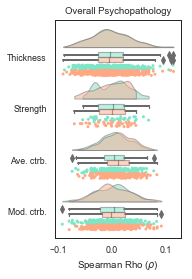

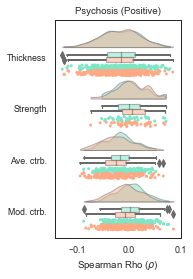

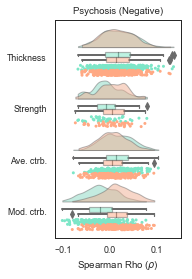

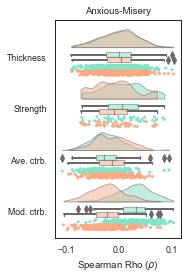

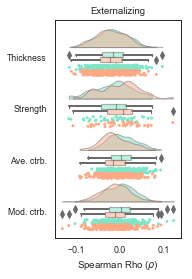

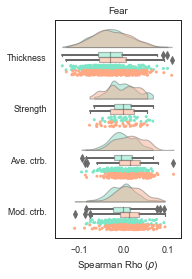

In [43]:
for i, pheno in enumerate(phenos):
    print(pheno)
    # nispat
    df1 = df_pheno.loc[pheno].reset_index()
    df1 = df1.loc[df1['node'].isin(metrics_labels),:]
    for metric in metrics:
        df1.replace(to_replace=metric+'.*$', value=metric, regex = True, inplace = True)
    df1['analysis'] = 'pre-nm'
    df1 = df1.loc[region_filter,:]

    # nispat
    df2 = df_pheno_z.loc[pheno].reset_index()
    df2 = df2.loc[df2['node'].isin(metrics_labels),:]
    for metric in metrics:
        df2.replace(to_replace=metric+'.*$', value=metric, regex = True, inplace = True)
    df2['analysis'] = 'nm'
    df2 = df2.loc[region_filter,:]

    df_rc = pd.concat((df1,df2), axis = 0)
#     df_rc['coef'] = df_rc['coef'].abs()

    # RainCloudPlot
    dx = 'node'; dy = 'coef'; dhue = "analysis"
    ort = 'h'; sigma = 0.25
    ax = pt.RainCloud(x = dx, y = dy, hue = dhue, data = df_rc, palette = cmap, bw = sigma, width_viol = 0.7, width_box=0.2,
                    figsize = (2.25,4), orient = ort, alpha = .5, dodge = True, pointplot = False, move = 0.25)
#                     figsize = (2.25,2), orient = ort, alpha = .5, dodge = True, pointplot = False, move = 0.25)
    ax.get_legend().remove()
    ax.set_title(phenos_label[i])
    ax.set_ylabel('')
    ax.set_yticklabels('')
    ax.set_yticklabels(metrics_label_short)
    ax.set_xlabel('Spearman Rho ($\\rho$)')
#     ax.set_xlabel('$\\rho$ (absolute)')
    plt.savefig('raincloud_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Summarise effects over Yeo networks

In [44]:
sns.set(style='white', context = 'paper', font_scale = 0.7)

Figure 4

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


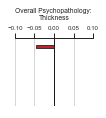

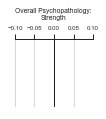

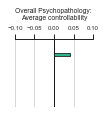

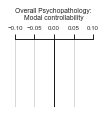

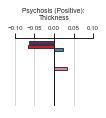

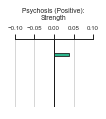

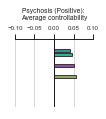

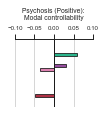

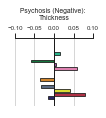

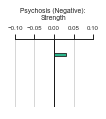

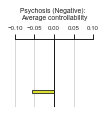

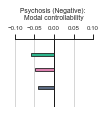

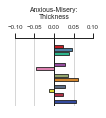

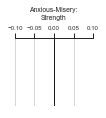

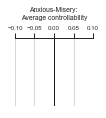

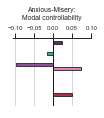

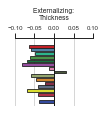

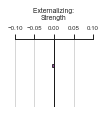

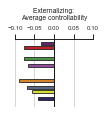

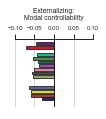

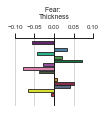

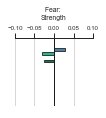

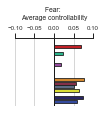

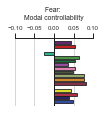

In [45]:
for i, pheno in enumerate(phenos):
    pheno_label = phenos_label[i]
    for j, metric in enumerate(metrics):
        metric_label = metrics_label[j]

        # Get coefficients and p-vals for phenotype effects
        coef = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
        p_vals = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['p_perm_fdr'].values # only plot significant coefficients
        sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_age_smse'].values
        p_vals[~sig] = 1
    
        # Summarise phenotype effects over systems
        # present mean effect in system
        sys_summary = get_sys_summary(coef, p_vals, yeo_idx, method = 'mean', alpha = alpha, signed = False)
        f, ax = prop_bar_plot(sys_summary, np.ones(sys_summary.shape), labels = '', which_colors = 'yeo17', axlim = 0.1, title_str = pheno_label + ': \n' + metric_label, fig_size = [1.4,1.25])
        f.savefig('corr_bar_' + pheno + '_' + metric + '_z.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Brain plots nispat

In [46]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [47]:
subject_id = 'fsaverage'

In [48]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots nispat

In [49]:
for pheno in phenos[5:]:
    for metric in metrics[0],:
        for hemi in ('lh', 'rh'):
            print(pheno, metric)
            # Plots of univariate pheno correlation
            fig_str = hemi + '_' + pheno + '_' + metric + '_z'
            roi_data = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_age_smse']

            roi_data[~sig] = -1000

            if any(sig):
                parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                             hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')
                # project subject's data to vertices
                brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi)
            else:
                print('Nothing significant')

Fear ct
0.112651757354616
colormap divergent: center=0.00e+00, [0.00e+00, 5.63e-02, 1.13e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.63e-02, 1.13e-01] (opaque)
Fear ct
0.11361443627925932
colormap divergent: center=0.00e+00, [0.00e+00, 5.68e-02, 1.14e-01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 5.68e-02, 1.14e-01] (opaque)


In [50]:
%matplotlib inline

Figure 4A

Fear
ct


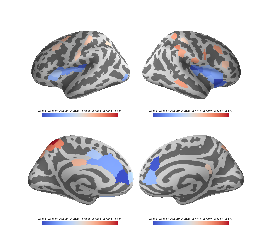

In [51]:
f, axes = plt.subplots(2, 2)
f.set_figwidth(4)
f.set_figheight(4)
plt.subplots_adjust(wspace=0, hspace=0)

pheno = phenos[5]; print(pheno)
metric = metrics[0]; print(metric)
# column 0:
fig_str = 'lh_'+pheno+'_'+metric+'_z.png'
try:
#     axes[0,0].set_title('Thickness (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'rh_'+pheno+'_'+metric+'_z.png'
try:
#     axes[0,1].set_title('Thickness (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')

plt.show()
f.savefig(metric+'_'+pheno+'_z.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)